In [1]:
!pip uninstall albumentations
!pip install opencv-python-headless==4.5.2.52
!pip install albumentations==0.5.2.
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Found existing installation: albumentations 0.1.12
Uninstalling albumentations-0.1.12:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/albumentations-0.1.12.dist-info/*
    /usr/local/lib/python3.7/dist-packages/albumentations/*
Proceed (y/n)? y
  Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 38.2 MB 104 kB/s 
     |████████████████████████████████| 72 kB 611 kB/s 
     |████████████████████████████████| 948 kB 35.1 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 24 kB/s 
     |████████████████████████████████| 12.7 MB 47.3 MB/s 
     |████████████████████████████████| 7.6 MB 14.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      S

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/캡스톤디자인

/content/drive/MyDrive/캡스톤디자인


In [4]:
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import cv2
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import json
import albumentations
import albumentations.pytorch

In [8]:
torchvision.__version__

'0.8.1+cu101'

In [6]:
ls

'1. pothole'/   Annotations/   retina_55.pt        test_images/
'2. filled'/    Images/        test_annotations/


In [7]:
cd 2. filled

/content/drive/MyDrive/캡스톤디자인/2. filled


In [9]:
print(len(os.listdir('Annotations/')))
print(len(os.listdir('Images/Images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

539
539
135
135


In [10]:
def generate_box(obj):
    
    xmin = obj['bbox'][0]
    ymin = obj['bbox'][1]
    xmax = obj['bbox'][0]+obj['bbox'][2]
    ymax = obj['bbox'][1]+obj['bbox'][3]
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj['category_id'] == 7: 
        return 7

    elif obj['category_id'] == 8: 
        return 8

    elif obj['category_id'] == 9:
      return 9
    return 0


def generate_target(file): 
    with open(f'{file}') as f:
        data = json.load(f)

        boxes = []
        labels = []
        for i in data['annotations']:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 7 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 8 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        
        elif annotation['labels'][idx] == 9 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects


class PotholeDataset(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-4] +'_BBOX.json'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join('test_annotations/', file_label)
    else:
      label_path = os.path.join('Annotations/', file_label)

    img = Image.open(img_path).convert('RGB')
    target = generate_target(label_path)

    to_tensor = torchvision.transforms.ToTensor()

    if self.transform:
      img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
      target['boxes'] = torch.as_tensor(transform_target)

    img = to_tensor(img)

    return img, target

def collate_fn(batch):
  return tuple(zip(*batch))

In [11]:
class BboxAugmentationDataset(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-4] +'_BBOX.json'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join('test_annotations/', file_label)
    else:
      label_path = os.path.join('Annotations/', file_label)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      
    target = generate_target(label_path)

    if self.transform:
      transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
      image = transformed['image']
      target = {'boxes':torch.as_tensor(transformed['bboxes']), 'labels':torch.as_tensor(transformed['labels'])}


    return image, target

In [12]:
# Image Processing
torchvision_transform = albumentations.Compose(
    [albumentations.Resize(320, 320),
     albumentations.pytorch.transforms.ToTensor()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

In [13]:
dataset = BboxAugmentationDataset('Images/Images/',torchvision_transform)
test_dataset = BboxAugmentationDataset('test_images/',torchvision_transform)

data_loader = torch.utils.data.DataLoader(dataset, batch_size = 4, collate_fn = collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, collate_fn = collate_fn)

In [14]:
img, annot = dataset[1]
print(np.shape(img))

torch.Size([3, 320, 320])


In [15]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes= 10, pretrained=False, pretrained_backbone= True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [17]:
num_epochs = 55
retina.to(device)

params = [p for p in retina.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005,
                            momentum = 0.9, weight_decay = 0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
  start = time.time()
  retina.train()

  i = 0
  epoch_loss = 0
  for images, targets in data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = retina(images, targets)

    losses = sum(loss for loss in loss_dict.values())

    i += 1

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    epoch_loss += losses 
  print(epoch_loss, f'time: {time.time() - start}')


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


tensor(255.5040, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 313.0429103374481
tensor(236.3720, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 95.71616268157959
tensor(235.3292, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 97.48806118965149
tensor(227.9937, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 98.54628586769104
tensor(213.6938, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 98.89066362380981
tensor(198.0798, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 98.90415382385254
tensor(188.0233, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 98.94834589958191
tensor(168.9088, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 99.0000569820404
tensor(163.5465, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>) time: 99.11560988426208
tensor(148.2773, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackwar

In [18]:
torch.cuda.is_available()

True

In [19]:
torch.save(retina.state_dict(),f'final_retina_{num_epochs}.pt')

In [ ]:
retina.load_state_dict(torch.load(f'final_retina_{num_epochs}.pt'))

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

In [31]:
# threshold miss
# torch.load('final_retina_55.pt')
%cd /content/drive/MyDrive/캡스톤디자인/2. filled


/content/drive/MyDrive/캡스톤디자인/2. filled


In [32]:
ls

Annotations/        Images/      retina_35.pt  test_annotations/
final_model_10.pt   model_10.pt  retina_50.pt  test_images/
final_retina_55.pt  model_20.pt  retina_65.pt  Tutorial-Book-Utils/


In [ ]:
torch.load('final_retina_55.pt')

In [22]:
def make_prediction(model, img, threshold):
  model.eval()
  preds = model(img)
  for id in range(len(preds)):
    idx_list = []

    for idx, score in enumerate(preds[id]['scores']):
      if score > threshold:
        idx_list.append(idx)

    preds[id]['boxes'] = preds[id]['boxes'][idx_list]
    preds[id]['labels'] = preds[id]['labels'][idx_list]
    preds[id]['scores'] = preds[id]['scores'][idx_list]

  
  return preds

In [34]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(test_data_loader, position = 0, leave = True):
  im =list(img.to(device) for img in im)
  # annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

  for t in annot:
    labels += t['labels']

  with torch.no_grad():
    preds_adj = make_prediction(retina, im, 0.5)
    preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
    preds_adj_all.append(preds_adj)
    annot_all.append(annot)

100%|██████████| 68/68 [00:15<00:00,  4.30it/s]


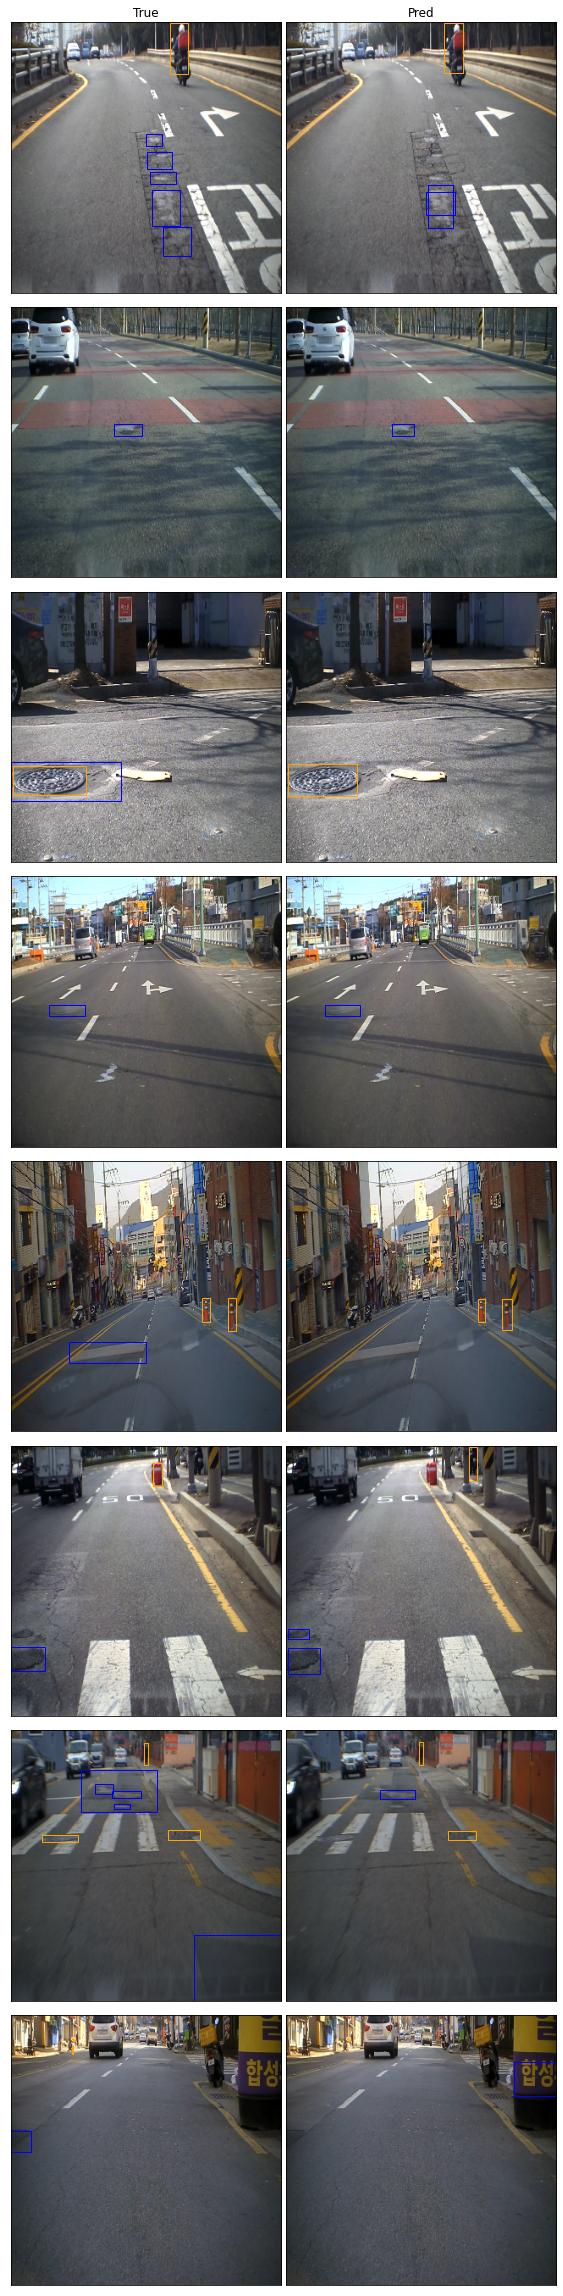

In [35]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in test_data_loader:
  pos = batch_i * 4 + 1
  for sample_i in range(len(im)):

    img, rects = plot_image_from_output(im[sample_i], annot[sample_i])
    axes[(pos)//2, 1-((pos)%2)].imshow(img)
    for rect in rects:
      axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
        
    img, rects = plot_image_from_output(im[sample_i], preds_adj_all[batch_i][sample_i])
    axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
    for rect in rects:
      axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)

    pos += 2

  batch_i += 1
  if batch_i == 4:
    break

for idx, ax in enumerate(axes.flat):
  ax.set_xticks([])
  ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
  ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()

In [37]:
# !git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

# %cd /content/drive/MyDrive/캡스톤디자인/1. pothole
import utils_ObjectDetection as utils

In [38]:
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

/content/drive/MyDrive/캡스톤디자인/2. filled/Tutorial-Book-Utils


In [39]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
  sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5)

In [40]:
true_positives, pred_score, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_score, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP)
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.4487458071758226
AP : tensor([0.4433, 0.4541], dtype=torch.float64)


In [41]:
print(preds_adj_all)

[[{'boxes': tensor([[186.3460,   0.0000, 209.4090,  59.8942],
        [167.5630, 191.5128, 196.6342, 243.0310],
        [165.3395, 199.8599, 199.2319, 227.6967]]), 'scores': tensor([0.9196, 0.7439, 0.5803]), 'labels': tensor([0, 9, 9])}, {'boxes': tensor([[125.3025, 138.2042, 150.3567, 152.3638]]), 'scores': tensor([0.9992]), 'labels': tensor([9])}], [{'boxes': tensor([[  1.9482, 203.8961,  83.3827, 241.4665]]), 'scores': tensor([0.9701]), 'labels': tensor([0])}, {'boxes': tensor([[ 45.7065, 152.3573,  86.7256, 164.8922]]), 'scores': tensor([0.9639]), 'labels': tensor([9])}], [{'boxes': tensor([[226.0764, 162.7597, 235.3409, 190.3171],
        [255.0182, 163.4311, 266.6741, 199.5811]]), 'scores': tensor([0.9698, 0.8892]), 'labels': tensor([0, 0])}, {'boxes': tensor([[216.0148,   0.6713, 225.2804,  41.5764],
        [  2.2688, 216.4833,  26.6228, 228.7828],
        [  1.2958, 238.6109,  39.0271, 269.5631]]), 'scores': tensor([0.9127, 0.9975, 0.9732]), 'labels': tensor([0, 9, 9])}], [{'b

In [ ]:
print(preds_adj)

In [ ]:
print(annot_all)

In [ ]:
print(annot)